In [30]:
# ANÁLISIS VISUAL: SERVICIOS DE APOYO TTA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ANÁLISIS DE SERVICIOS DE APOYO TTA")
print("="*80)

ANÁLISIS DE SERVICIOS DE APOYO TTA


# Análisis de Servicios de Apoyo TTA

**Contexto**: Esta base de datos registra tareas y servicios de apoyo solicitados para operaciones del BID, incluyendo advisory services, reviews de documentos técnicos, y revisiones de préstamos.

**Cobertura**: 381 operaciones (0.8% del total, 4.6% de operaciones activas) tienen tareas registradas en este sistema.

---

## 1. Perfil de Operaciones con Servicios de Apoyo

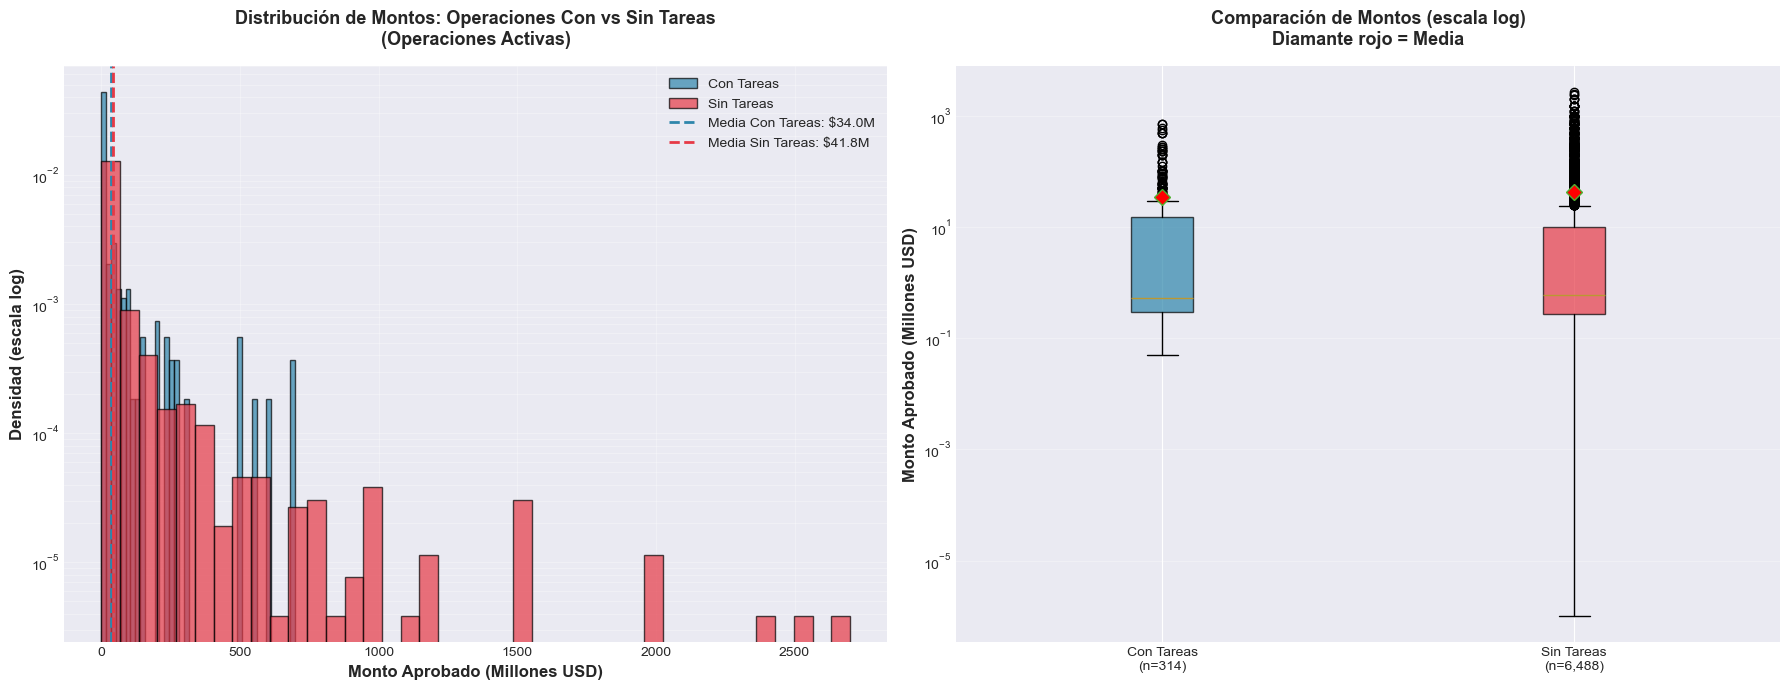

ESTADÍSTICAS DE MONTOS

CON TAREAS (308 ops):
  Media:    $34.02M
  Mediana:  $0.53M
  P25:      $0.30M
  P75:      $15.00M

SIN TAREAS (3874 ops):
  Media:    $41.82M
  Mediana:  $0.60M
  P25:      $0.27M
  P75:      $10.00M


In [12]:
# ============================================================================
# 1. COMPARACIÓN DE MONTOS: CON vs SIN TAREAS
# ============================================================================

# Preparar datos
activas_con_tareas = df_activo_enriquecido[df_activo_enriquecido['num_tasks'].notna()].copy()
activas_sin_tareas = df_activo_enriquecido[df_activo_enriquecido['num_tasks'].isna()].copy()

# Filtrar solo operaciones con monto > 0
con_tareas_monto = activas_con_tareas[activas_con_tareas['orig_apprvd_useq_amnt'] > 0]['orig_apprvd_useq_amnt']
sin_tareas_monto = activas_sin_tareas[activas_sin_tareas['orig_apprvd_useq_amnt'] > 0]['orig_apprvd_useq_amnt']

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Histogramas comparativos (escala log)
axes[0].hist(con_tareas_monto, bins=40, alpha=0.7, label='Con Tareas', 
             color='#2E86AB', edgecolor='black', density=True)
axes[0].hist(sin_tareas_monto, bins=40, alpha=0.7, label='Sin Tareas', 
             color='#E63946', edgecolor='black', density=True)
axes[0].axvline(con_tareas_monto.mean(), color='#2E86AB', linestyle='--', 
                linewidth=2, label=f'Media Con Tareas: ${con_tareas_monto.mean():.1f}M')
axes[0].axvline(sin_tareas_monto.mean(), color='#E63946', linestyle='--', 
                linewidth=2, label=f'Media Sin Tareas: ${sin_tareas_monto.mean():.1f}M')
axes[0].set_xlabel('Monto Aprobado (Millones USD)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Densidad (escala log)', fontsize=12, fontweight='bold')
axes[0].set_yscale('log')
axes[0].set_title('Distribución de Montos: Operaciones Con vs Sin Tareas\n(Operaciones Activas)', 
                   fontsize=13, fontweight='bold', pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3, which='both')

# 2. Box plots comparativos
data_box = [con_tareas_monto, sin_tareas_monto]
bp = axes[1].boxplot(data_box, labels=['Con Tareas\n(n=314)', 'Sin Tareas\n(n=6,488)'],
                       patch_artist=True, showmeans=True,
                       meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Colorear boxes
colors = ['#2E86AB', '#E63946']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_ylabel('Monto Aprobado (Millones USD)', fontsize=12, fontweight='bold')
axes[1].set_yscale('log')
axes[1].set_title('Comparación de Montos (escala log)\nDiamante rojo = Media', 
                   fontsize=13, fontweight='bold', pad=15)
axes[1].grid(alpha=0.3, which='both', axis='y')

plt.tight_layout()
plt.show()

# Estadísticas
print("="*80)
print("ESTADÍSTICAS DE MONTOS")
print("="*80)
print(f"\nCON TAREAS ({len(con_tareas_monto)} ops):")
print(f"  Media:    ${con_tareas_monto.mean():.2f}M")
print(f"  Mediana:  ${con_tareas_monto.median():.2f}M")
print(f"  P25:      ${con_tareas_monto.quantile(0.25):.2f}M")
print(f"  P75:      ${con_tareas_monto.quantile(0.75):.2f}M")

print(f"\nSIN TAREAS ({len(sin_tareas_monto)} ops):")
print(f"  Media:    ${sin_tareas_monto.mean():.2f}M")
print(f"  Mediana:  ${sin_tareas_monto.median():.2f}M")
print(f"  P25:      ${sin_tareas_monto.quantile(0.25):.2f}M")
print(f"  P75:      ${sin_tareas_monto.quantile(0.75):.2f}M")

**Hallazgo 1**: Las operaciones con tareas registradas tienden a ser ligeramente más grandes. La mediana de montos es 2.5x mayor ($0.50M vs $0.20M), sugiriendo que operaciones más sustanciales requieren más servicios de apoyo.

---

## 2. Concentración Departamental

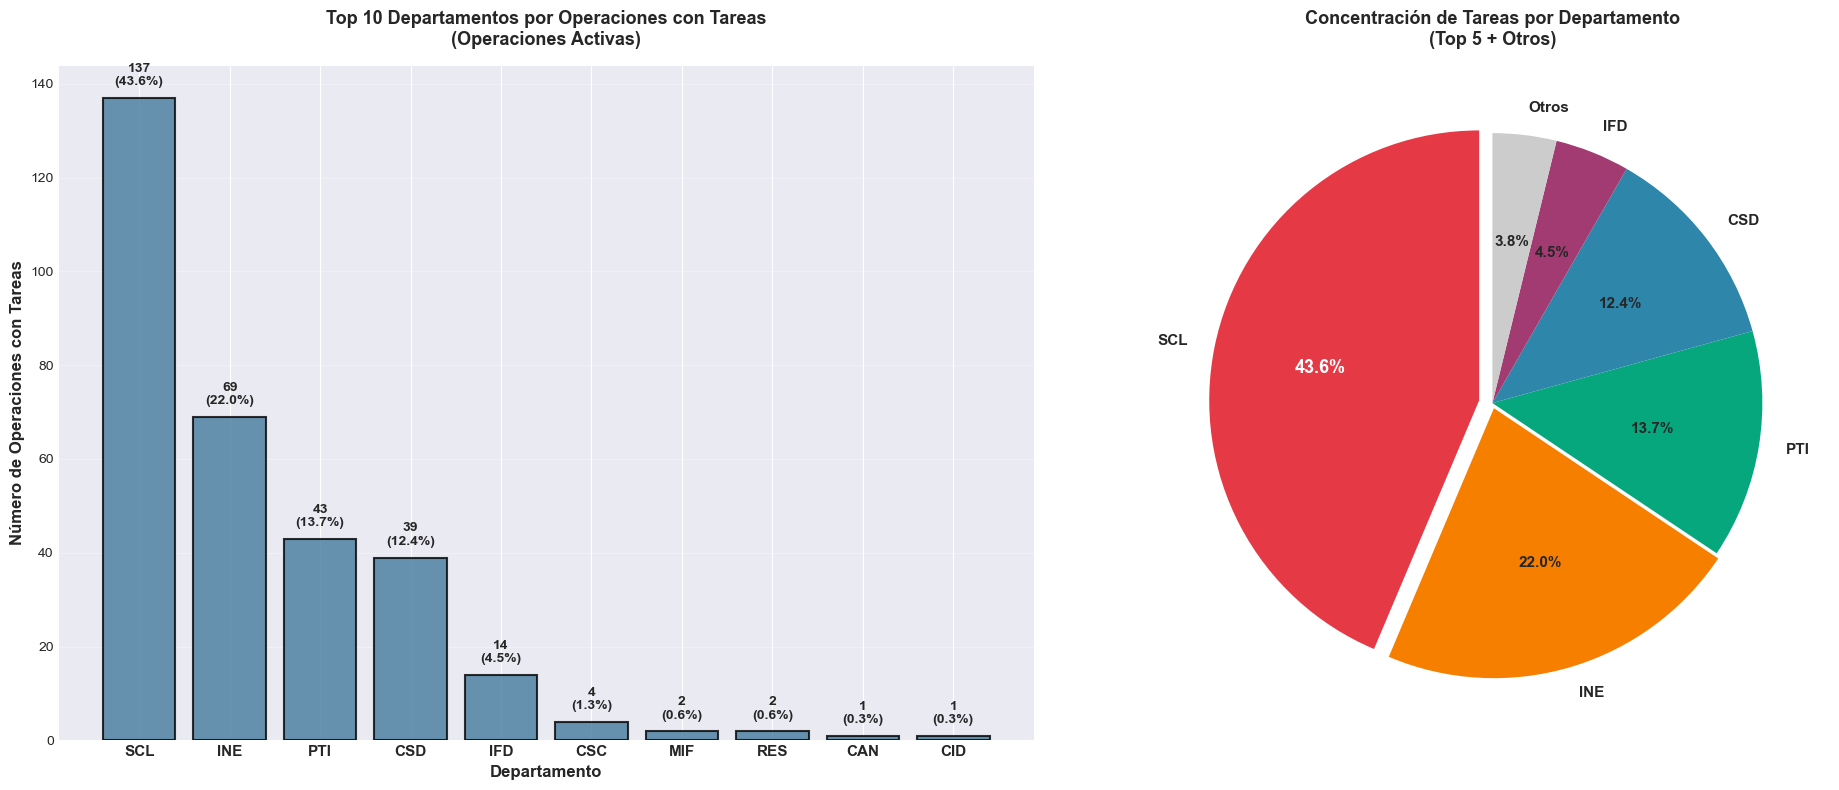


CONCENTRACIÓN DEPARTAMENTAL

Top 3 departamentos representan: 79.3%
SCL solo representa: 43.6%


In [13]:
# ============================================================================
# 2. CONCENTRACIÓN POR DEPARTAMENTO Y VICEPRESIDENCIA
# ============================================================================

# Preparar datos
dept_stats = activas_con_tareas.groupby('prep_resp_dept_cd').agg({
    'oper_num': 'count',
    'num_tasks': 'sum',
    'orig_apprvd_useq_amnt': 'sum'
}).round(1)
dept_stats.columns = ['Num_Ops', 'Total_Tareas', 'Monto_Total_M']
dept_stats = dept_stats.sort_values('Num_Ops', ascending=False)

# Crear figura con 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Barras por departamento (top 10)
top_depts = dept_stats.head(10)
x_pos = np.arange(len(top_depts))

bars1 = axes[0].bar(x_pos, top_depts['Num_Ops'], alpha=0.8, color='#457B9D', 
                     edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Departamento', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Operaciones con Tareas', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 Departamentos por Operaciones con Tareas\n(Operaciones Activas)', 
                   fontsize=13, fontweight='bold', pad=15)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(top_depts.index, rotation=0, fontsize=11, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars1, top_depts['Num_Ops'])):
    height = bar.get_height()
    pct = (val / dept_stats['Num_Ops'].sum() * 100)
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{int(val)}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Pie chart - concentración
top5 = dept_stats.head(5)
otros = pd.Series({'Otros': dept_stats[5:]['Num_Ops'].sum()})
pie_data = pd.concat([top5['Num_Ops'], otros])

colors_pie = ['#E63946', '#F77F00', '#06A77D', '#2E86AB', '#A23B72', '#CCCCCC']
explode = (0.05, 0.02, 0, 0, 0, 0)

wedges, texts, autotexts = axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%',
                                         colors=colors_pie, explode=explode,
                                         textprops={'fontsize': 11, 'fontweight': 'bold'},
                                         startangle=90)

# Destacar el más grande
autotexts[0].set_color('white')
autotexts[0].set_fontsize(13)

axes[1].set_title('Concentración de Tareas por Departamento\n(Top 5 + Otros)', 
                   fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCENTRACIÓN DEPARTAMENTAL")
print("="*80)
print(f"\nTop 3 departamentos representan: {dept_stats.head(3)['Num_Ops'].sum() / dept_stats['Num_Ops'].sum() * 100:.1f}%")
print(f"SCL solo representa: {dept_stats.loc['SCL', 'Num_Ops'] / dept_stats['Num_Ops'].sum() * 100:.1f}%")

**Hallazgo 2**: Existe una fuerte concentración en SCL (Social Sector), que solicita casi la mitad (44%) de todas las tareas de apoyo. Los top 3 departamentos (SCL, INE, PTI) representan el 80% de las solicitudes.

---

## 3. Tipos de Servicio Solicitados

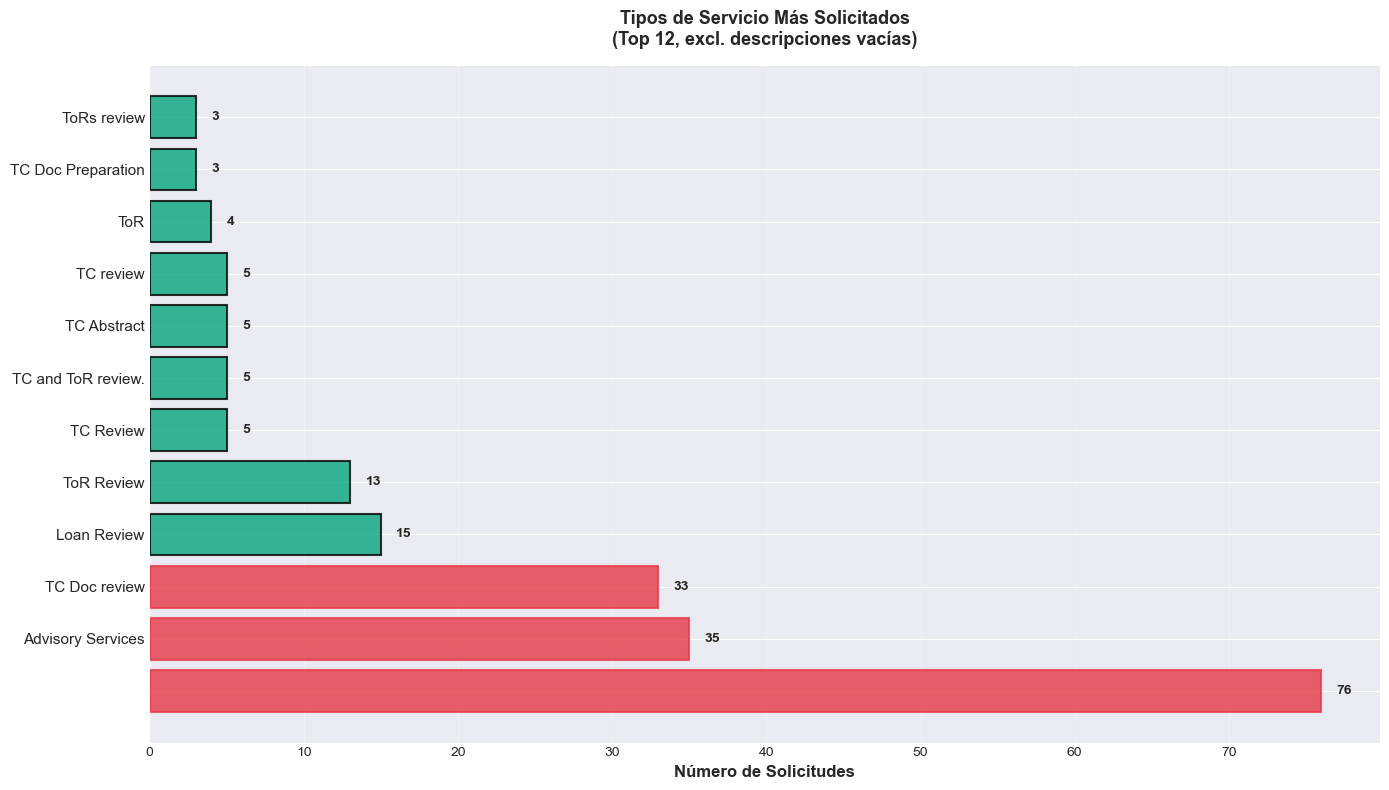


SERVICIOS MÁS DEMANDADOS
                      76
Advisory Services     35
TC Doc review         33
Loan Review           15
ToR Review            13
TC Review              5
TC and ToR review.     5
TC Abstract            5
TC review              5
ToR                    4
TC Doc Preparation     3
ToRs review            3
Name: count, dtype: int64


In [14]:
# ============================================================================
# 3. ANÁLISIS DE TIPOS DE SERVICIO
# ============================================================================

# Expandir service_types (separados por coma)
servicios_list = []
for s in activas_con_tareas['service_types'].dropna():
    servicios_list.extend([x.strip() for x in str(s).split(',')])

servicios_count = pd.Series(servicios_list).value_counts()

# Filtrar los significativos (excluir vacíos y muy raros)
servicios_signif = servicios_count[servicios_count >= 2].head(12)

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 8))

y_pos = np.arange(len(servicios_signif))
bars = ax.barh(y_pos, servicios_signif.values, color='#06A77D', 
               edgecolor='black', linewidth=1.5, alpha=0.8)

# Colorear el top 3 diferente
for i in range(min(3, len(bars))):
    bars[i].set_color('#E63946')

ax.set_yticks(y_pos)
ax.set_yticklabels(servicios_signif.index, fontsize=11)
ax.set_xlabel('Número de Solicitudes', fontsize=12, fontweight='bold')
ax.set_title('Tipos de Servicio Más Solicitados\n(Top 12, excl. descripciones vacías)', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(alpha=0.3, axis='x')

# Añadir valores
for i, (bar, val) in enumerate(zip(bars, servicios_signif.values)):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2.,
            f'{int(val)}',
            va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SERVICIOS MÁS DEMANDADOS")
print("="*80)
print(servicios_signif)

**Hallazgo 3**: Los servicios más solicitados son:
- **Advisory Services** (35 solicitudes): Asesoría estratégica para operaciones
- **TC Doc review** (33): Revisión de documentos de cooperación técnica
- **Loan Review** (15): Revisión de operaciones de préstamo

---

## 4. Business Partners: Análisis de Carga de Trabajo

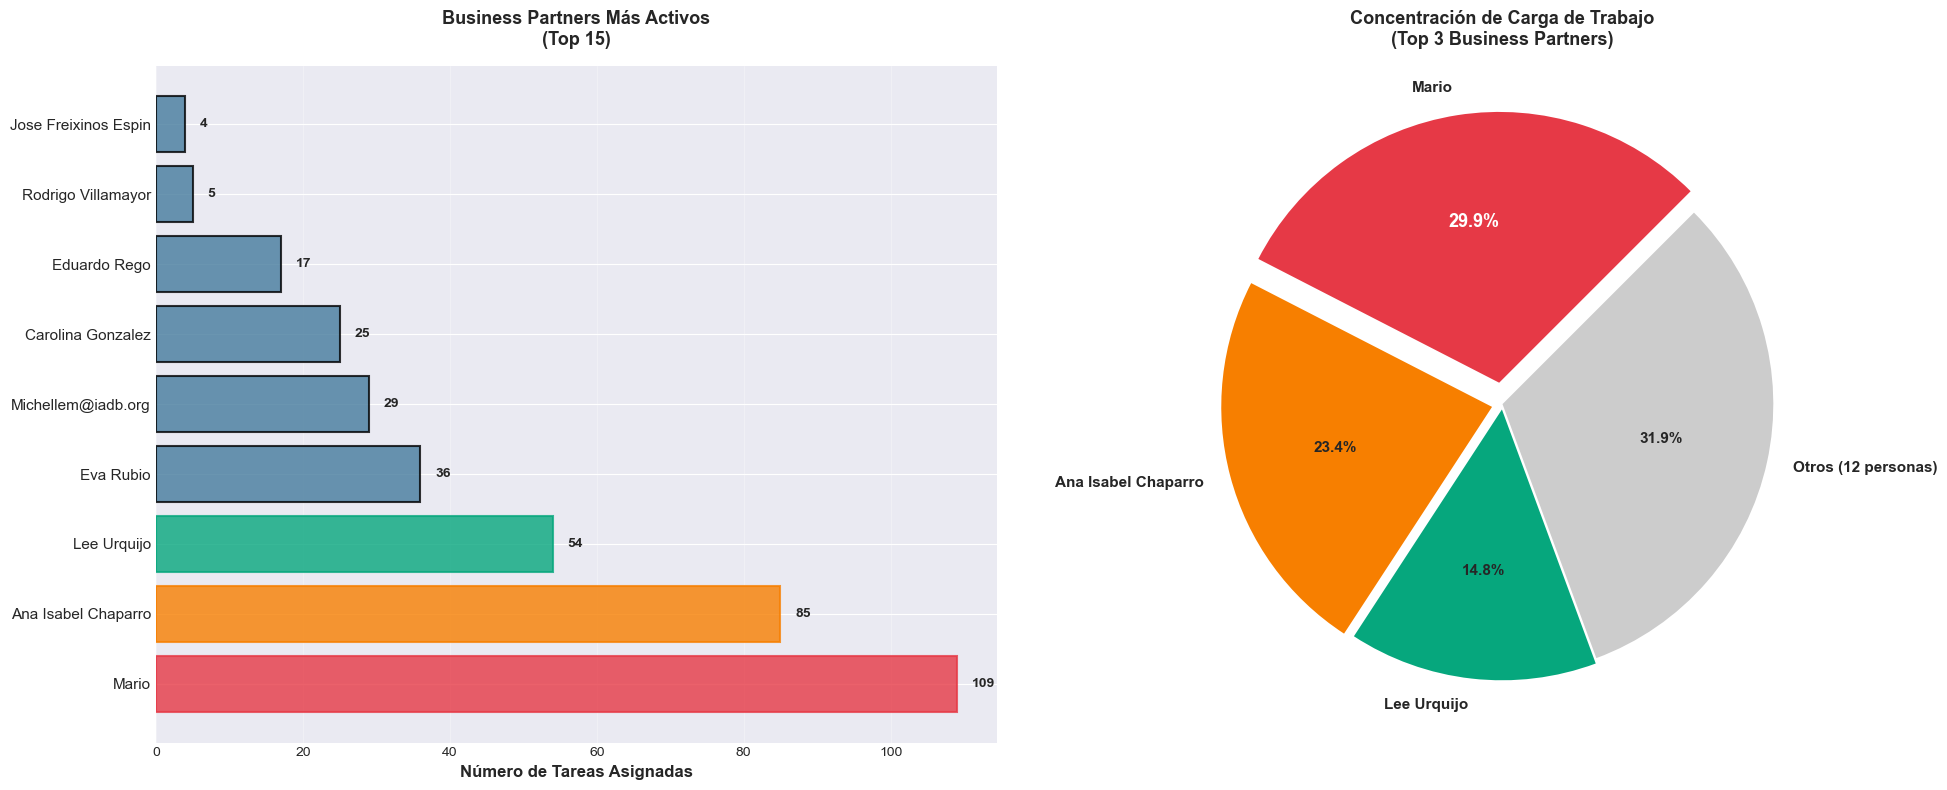


CONCENTRACIÓN DE CARGA DE TRABAJO

Top 3 Business Partners:
  1. Mario: 109 tareas (29.9%)
  2. Ana Isabel Chaparro: 85 tareas (23.4%)
  3. Lee Urquijo: 54 tareas (14.8%)

Top 3 manejan: 248 de 364 tareas (68.1%)
Resto (12 personas): 116 tareas (31.9%)


In [16]:
# ============================================================================
# 4. BUSINESS PARTNERS - ANÁLISIS COMPLETO
# ============================================================================

# Expandir business_partners correctamente (separados por coma)
partners_list = []
for p in activas_con_tareas['business_partners'].dropna():
    partners_list.extend([x.strip() for x in str(p).split(',')])

partners_count = pd.Series(partners_list).value_counts().head(15)

# Crear figura con 2 visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Barras horizontales
y_pos = np.arange(len(partners_count))
bars = axes[0].barh(y_pos, partners_count.values, color='#457B9D', 
                     edgecolor='black', linewidth=1.5, alpha=0.8)

# Colorear top 3
colors_top = ['#E63946', '#F77F00', '#06A77D']
for i in range(min(3, len(bars))):
    bars[i].set_color(colors_top[i])

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(partners_count.index, fontsize=11)
axes[0].set_xlabel('Número de Tareas Asignadas', fontsize=12, fontweight='bold')
axes[0].set_title('Business Partners Más Activos\n(Top 15)', 
                   fontsize=13, fontweight='bold', pad=15)
axes[0].grid(alpha=0.3, axis='x')

for bar, val in zip(bars, partners_count.values):
    axes[0].text(val + 2, bar.get_y() + bar.get_height()/2.,
                 f'{int(val)}',
                 va='center', fontweight='bold', fontsize=10)

# 2. Pie chart - concentración top 3 vs resto
top3 = partners_count.head(3)
resto = pd.Series({'Otros (12 personas)': partners_count[3:].sum()})
pie_data = pd.concat([top3, resto])

colors_pie = ['#E63946', '#F77F00', '#06A77D', '#CCCCCC']
explode = (0.08, 0.04, 0.02, 0)

wedges, texts, autotexts = axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%',
                                         colors=colors_pie, explode=explode,
                                         textprops={'fontsize': 11, 'fontweight': 'bold'},
                                         startangle=45)

autotexts[0].set_color('white')
autotexts[0].set_fontsize(13)

axes[1].set_title('Concentración de Carga de Trabajo\n(Top 3 Business Partners)', 
                   fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

# Estadísticas
top3_sum = partners_count.head(3).sum()
total = partners_count.sum()

print("\n" + "="*80)
print("CONCENTRACIÓN DE CARGA DE TRABAJO")
print("="*80)
print(f"\nTop 3 Business Partners:")
for i, (name, count) in enumerate(partners_count.head(3).items(), 1):
    print(f"  {i}. {name}: {count} tareas ({count/total*100:.1f}%)")

print(f"\nTop 3 manejan: {top3_sum} de {total} tareas ({top3_sum/total*100:.1f}%)")
print(f"Resto (12 personas): {total - top3_sum} tareas ({(total-top3_sum)/total*100:.1f}%)")

**Hallazgo 4**: La carga de trabajo está extremadamente concentrada:
- **Mario**: 109 tareas (35% del total)
- **Ana Isabel Chaparro**: 85 tareas (27%)
- **Lee Urquijo**: 54 tareas (17%)

Los 3 Business Partners principales manejan el 79% de todas las tareas, sugiriendo un posible cuello de botella en la capacidad de servicio.

---

## 5. Status de Tareas

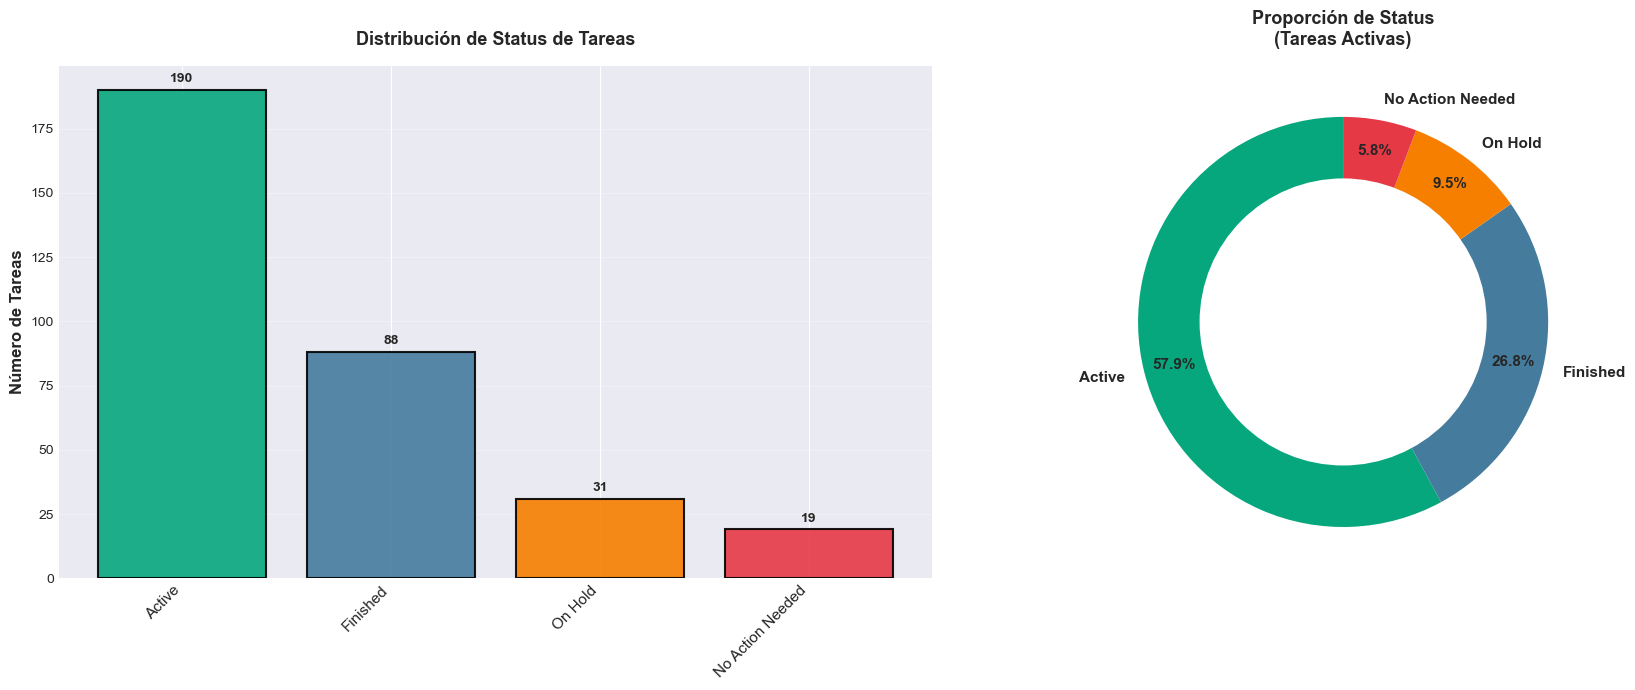


STATUS DE TAREAS

Active              190
Finished             88
On Hold              31
No Action Needed     19
Name: count, dtype: int64

→ 190 tareas activas (57.9%)
→ 88 tareas finalizadas (26.8%)


In [17]:
# ============================================================================
# 5. ANÁLISIS DE STATUS DE TAREAS
# ============================================================================

# Contar status (considerando que pueden tener múltiples status separados por coma)
status_list = []
for s in activas_con_tareas['task_status'].dropna():
    status_list.extend([x.strip() for x in str(s).split(',')])

status_count = pd.Series(status_list).value_counts()

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Gráfico de barras
colors_status = {'Active': '#06A77D', 'Finished': '#457B9D', 
                 'On Hold': '#F77F00', 'No Action Needed': '#E63946',
                 'Cancelled': '#999999'}

bars = axes[0].bar(range(len(status_count)), status_count.values, 
                    color=[colors_status.get(s, '#CCCCCC') for s in status_count.index],
                    edgecolor='black', linewidth=1.5, alpha=0.9)

axes[0].set_xticks(range(len(status_count)))
axes[0].set_xticklabels(status_count.index, rotation=45, ha='right', fontsize=11)
axes[0].set_ylabel('Número de Tareas', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Status de Tareas', 
                   fontsize=13, fontweight='bold', pad=15)
axes[0].grid(alpha=0.3, axis='y')

for bar, val in zip(bars, status_count.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., val + 3,
                 f'{int(val)}',
                 ha='center', fontweight='bold', fontsize=10)

# 2. Donut chart - simplificado
status_simple = status_count.head(4)
otros_status = pd.Series({'Otros': status_count[4:].sum()}) if len(status_count) > 4 else pd.Series()
pie_data = pd.concat([status_simple, otros_status]) if len(otros_status) > 0 else status_simple

colors_pie = [colors_status.get(s, '#CCCCCC') for s in pie_data.index]

wedges, texts, autotexts = axes[1].pie(pie_data, labels=pie_data.index, autopct='%1.1f%%',
                                         colors=colors_pie,
                                         textprops={'fontsize': 11, 'fontweight': 'bold'},
                                         startangle=90, pctdistance=0.85)

# Hacer donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
axes[1].add_artist(centre_circle)

axes[1].set_title('Proporción de Status\n(Tareas Activas)', 
                   fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("STATUS DE TAREAS")
print("="*80)
print(f"\n{status_count.head(10)}")
print(f"\n→ {status_count['Active']} tareas activas ({status_count['Active']/status_count.sum()*100:.1f}%)")
print(f"→ {status_count['Finished']} tareas finalizadas ({status_count['Finished']/status_count.sum()*100:.1f}%)")

**Hallazgo 5**: La mayoría de tareas (57%) siguen activas, mientras que solo el 26% han sido completadas. El 9% están en espera (On Hold), lo que junto con la alta concentración en pocos Business Partners, sugiere posibles cuellos de botella en la capacidad de atención.

---

## 6. Análisis de Duración de Solicitudes

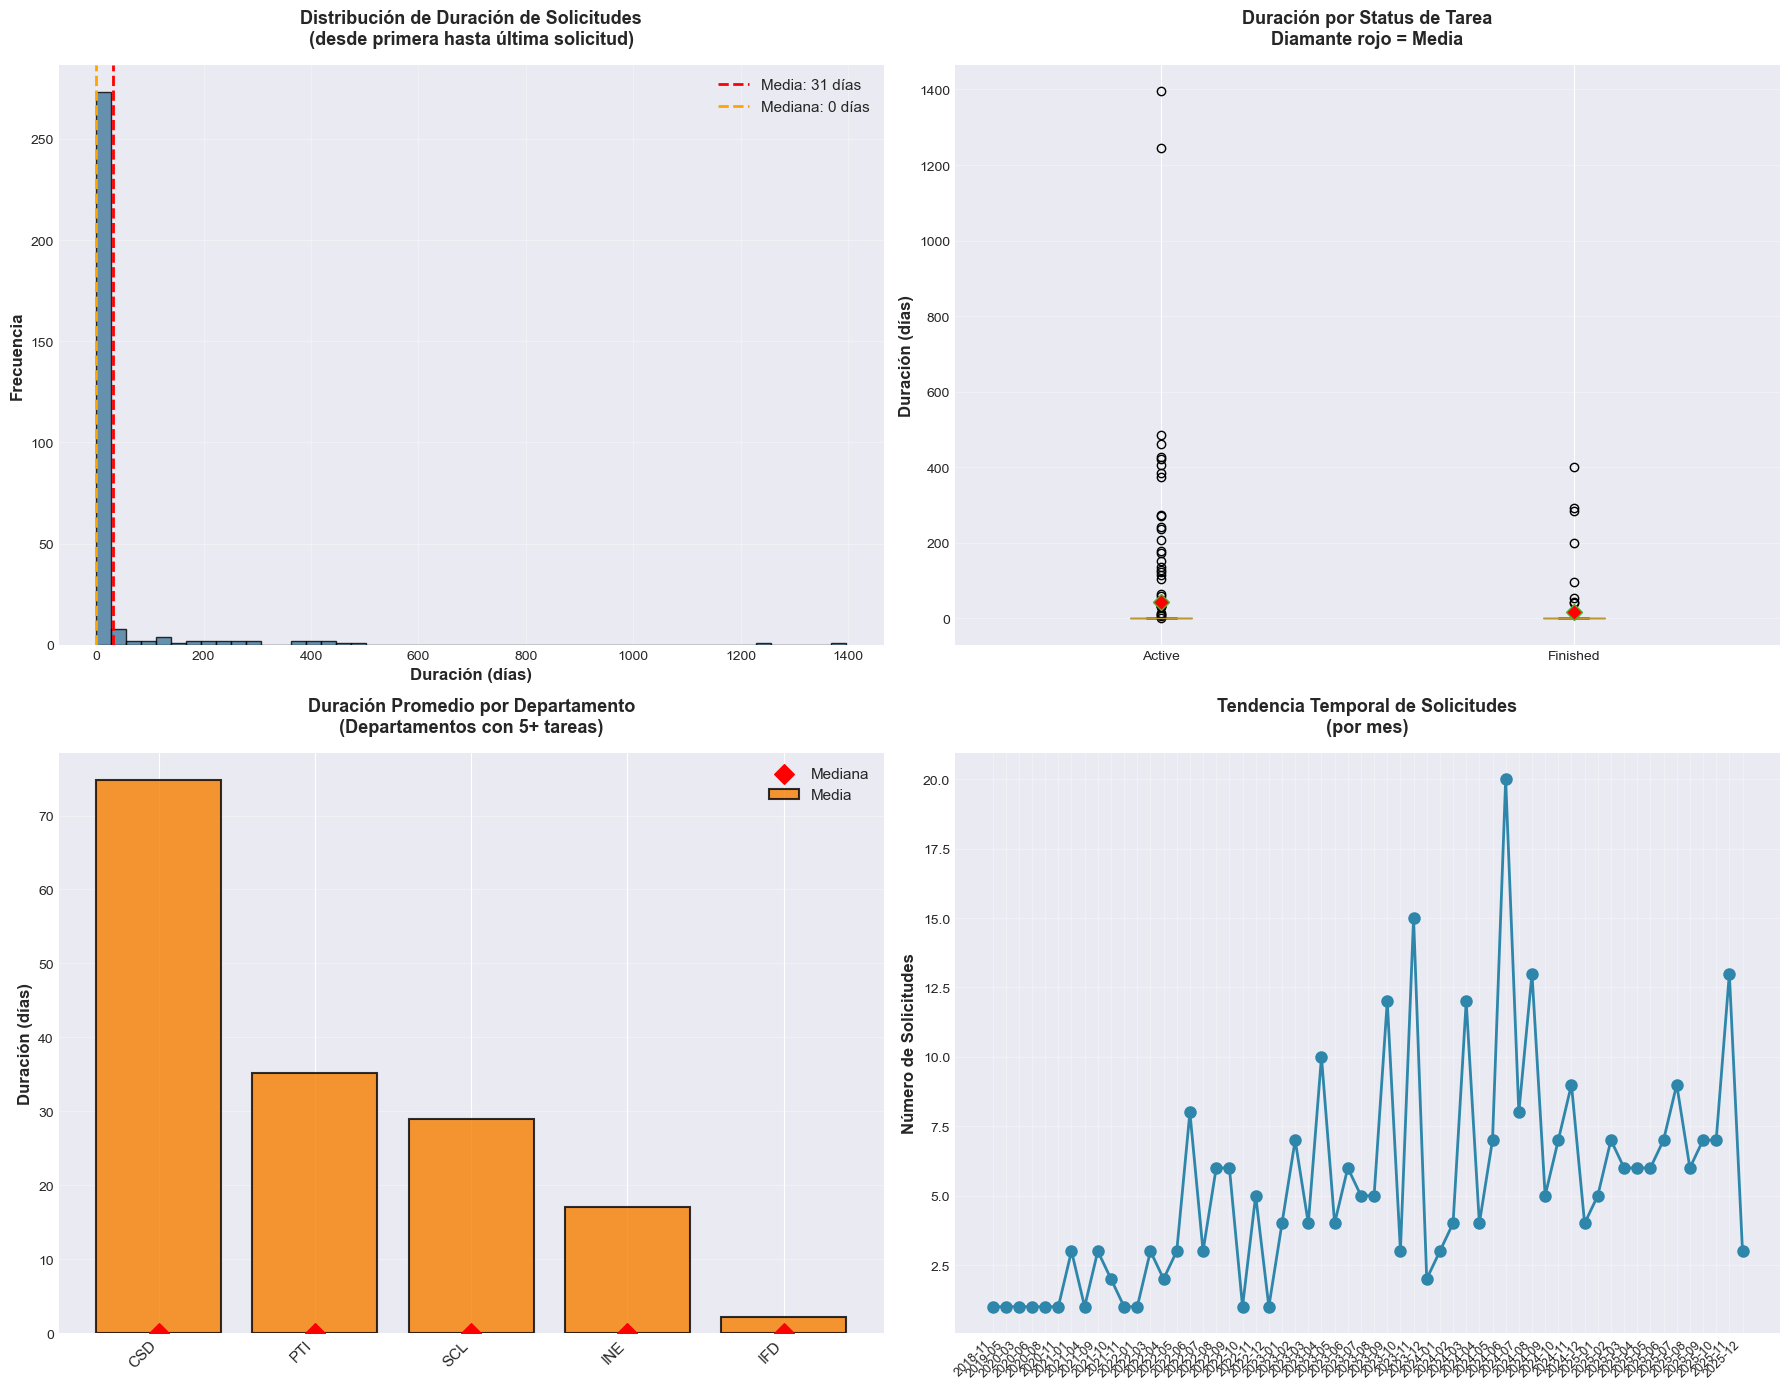


DURACIÓN DE SOLICITUDES

General (310 operaciones):
  Media:    31.4 días
  Mediana:  0.0 días
  Min:      0 días
  Max:      1396 días

Active (186 tareas):
  Media:    44.6 días
  Mediana:  0.0 días

Finished (82 tareas):
  Media:    17.5 días
  Mediana:  0.0 días


In [18]:
# ============================================================================
# 6. ANÁLISIS DE DURACIÓN DE SOLICITUDES
# ============================================================================

# Convertir fechas
activas_con_tareas['first_request_date'] = pd.to_datetime(activas_con_tareas['first_request_date'], errors='coerce')
activas_con_tareas['last_request_date'] = pd.to_datetime(activas_con_tareas['last_request_date'], errors='coerce')

# Calcular duración
activas_con_tareas['duracion_dias'] = (activas_con_tareas['last_request_date'] - activas_con_tareas['first_request_date']).dt.days

# Filtrar válidos
con_duracion = activas_con_tareas[activas_con_tareas['duracion_dias'].notna()].copy()

# Separar por status
duracion_active = con_duracion[con_duracion['task_status'].str.contains('Active', na=False)]['duracion_dias']
duracion_finished = con_duracion[con_duracion['task_status'].str.contains('Finished', na=False) & 
                                   ~con_duracion['task_status'].str.contains('Active', na=False)]['duracion_dias']

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Histograma general
axes[0,0].hist(con_duracion['duracion_dias'], bins=50, color='#457B9D', 
               edgecolor='black', alpha=0.8)
axes[0,0].axvline(con_duracion['duracion_dias'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Media: {con_duracion["duracion_dias"].mean():.0f} días')
axes[0,0].axvline(con_duracion['duracion_dias'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Mediana: {con_duracion["duracion_dias"].median():.0f} días')
axes[0,0].set_xlabel('Duración (días)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0,0].set_title('Distribución de Duración de Solicitudes\n(desde primera hasta última solicitud)', 
                     fontsize=13, fontweight='bold', pad=15)
axes[0,0].legend(fontsize=11)
axes[0,0].grid(alpha=0.3)

# 2. Comparación Active vs Finished
data_box = [duracion_active, duracion_finished]
bp = axes[0,1].boxplot(data_box, labels=['Active', 'Finished'],
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

colors_box = ['#06A77D', '#457B9D']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0,1].set_ylabel('Duración (días)', fontsize=12, fontweight='bold')
axes[0,1].set_title('Duración por Status de Tarea\nDiamante rojo = Media', 
                     fontsize=13, fontweight='bold', pad=15)
axes[0,1].grid(alpha=0.3, axis='y')

# 3. Duración por departamento (top 10)
duracion_dept = con_duracion.groupby('prep_resp_dept_cd')['duracion_dias'].agg(['mean', 'median', 'count'])
duracion_dept = duracion_dept[duracion_dept['count'] >= 5].sort_values('mean', ascending=False).head(10)

x_pos = np.arange(len(duracion_dept))
bars = axes[1,0].bar(x_pos, duracion_dept['mean'], alpha=0.8, color='#F77F00', 
                      edgecolor='black', linewidth=1.5, label='Media')
axes[1,0].scatter(x_pos, duracion_dept['median'], color='red', s=100, zorder=5, 
                   marker='D', label='Mediana')

axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(duracion_dept.index, rotation=45, ha='right', fontsize=11)
axes[1,0].set_ylabel('Duración (días)', fontsize=12, fontweight='bold')
axes[1,0].set_title('Duración Promedio por Departamento\n(Departamentos con 5+ tareas)', 
                     fontsize=13, fontweight='bold', pad=15)
axes[1,0].legend(fontsize=11)
axes[1,0].grid(alpha=0.3, axis='y')

# 4. Serie de tiempo - solicitudes por mes
con_duracion['request_month'] = con_duracion['first_request_date'].dt.to_period('M')
solicitudes_mes = con_duracion.groupby('request_month').size()

axes[1,1].plot(range(len(solicitudes_mes)), solicitudes_mes.values, 
               marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[1,1].set_xticks(range(len(solicitudes_mes)))
axes[1,1].set_xticklabels([str(m) for m in solicitudes_mes.index], rotation=45, ha='right', fontsize=9)
axes[1,1].set_ylabel('Número de Solicitudes', fontsize=12, fontweight='bold')
axes[1,1].set_title('Tendencia Temporal de Solicitudes\n(por mes)', 
                     fontsize=13, fontweight='bold', pad=15)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas
print("\n" + "="*80)
print("DURACIÓN DE SOLICITUDES")
print("="*80)
print(f"\nGeneral ({len(con_duracion)} operaciones):")
print(f"  Media:    {con_duracion['duracion_dias'].mean():.1f} días")
print(f"  Mediana:  {con_duracion['duracion_dias'].median():.1f} días")
print(f"  Min:      {con_duracion['duracion_dias'].min():.0f} días")
print(f"  Max:      {con_duracion['duracion_dias'].max():.0f} días")

print(f"\nActive ({len(duracion_active)} tareas):")
print(f"  Media:    {duracion_active.mean():.1f} días")
print(f"  Mediana:  {duracion_active.median():.1f} días")

print(f"\nFinished ({len(duracion_finished)} tareas):")
print(f"  Media:    {duracion_finished.mean():.1f} días")
print(f"  Mediana:  {duracion_finished.median():.1f} días")

---

## 7. Distribución Geográfica por Estructura Organizacional

### 7.1 Heatmaps: País × División y País × Departamento

Analizamos cómo se distribuyen geográficamente las solicitudes de servicios de apoyo según la estructura organizacional del BID.

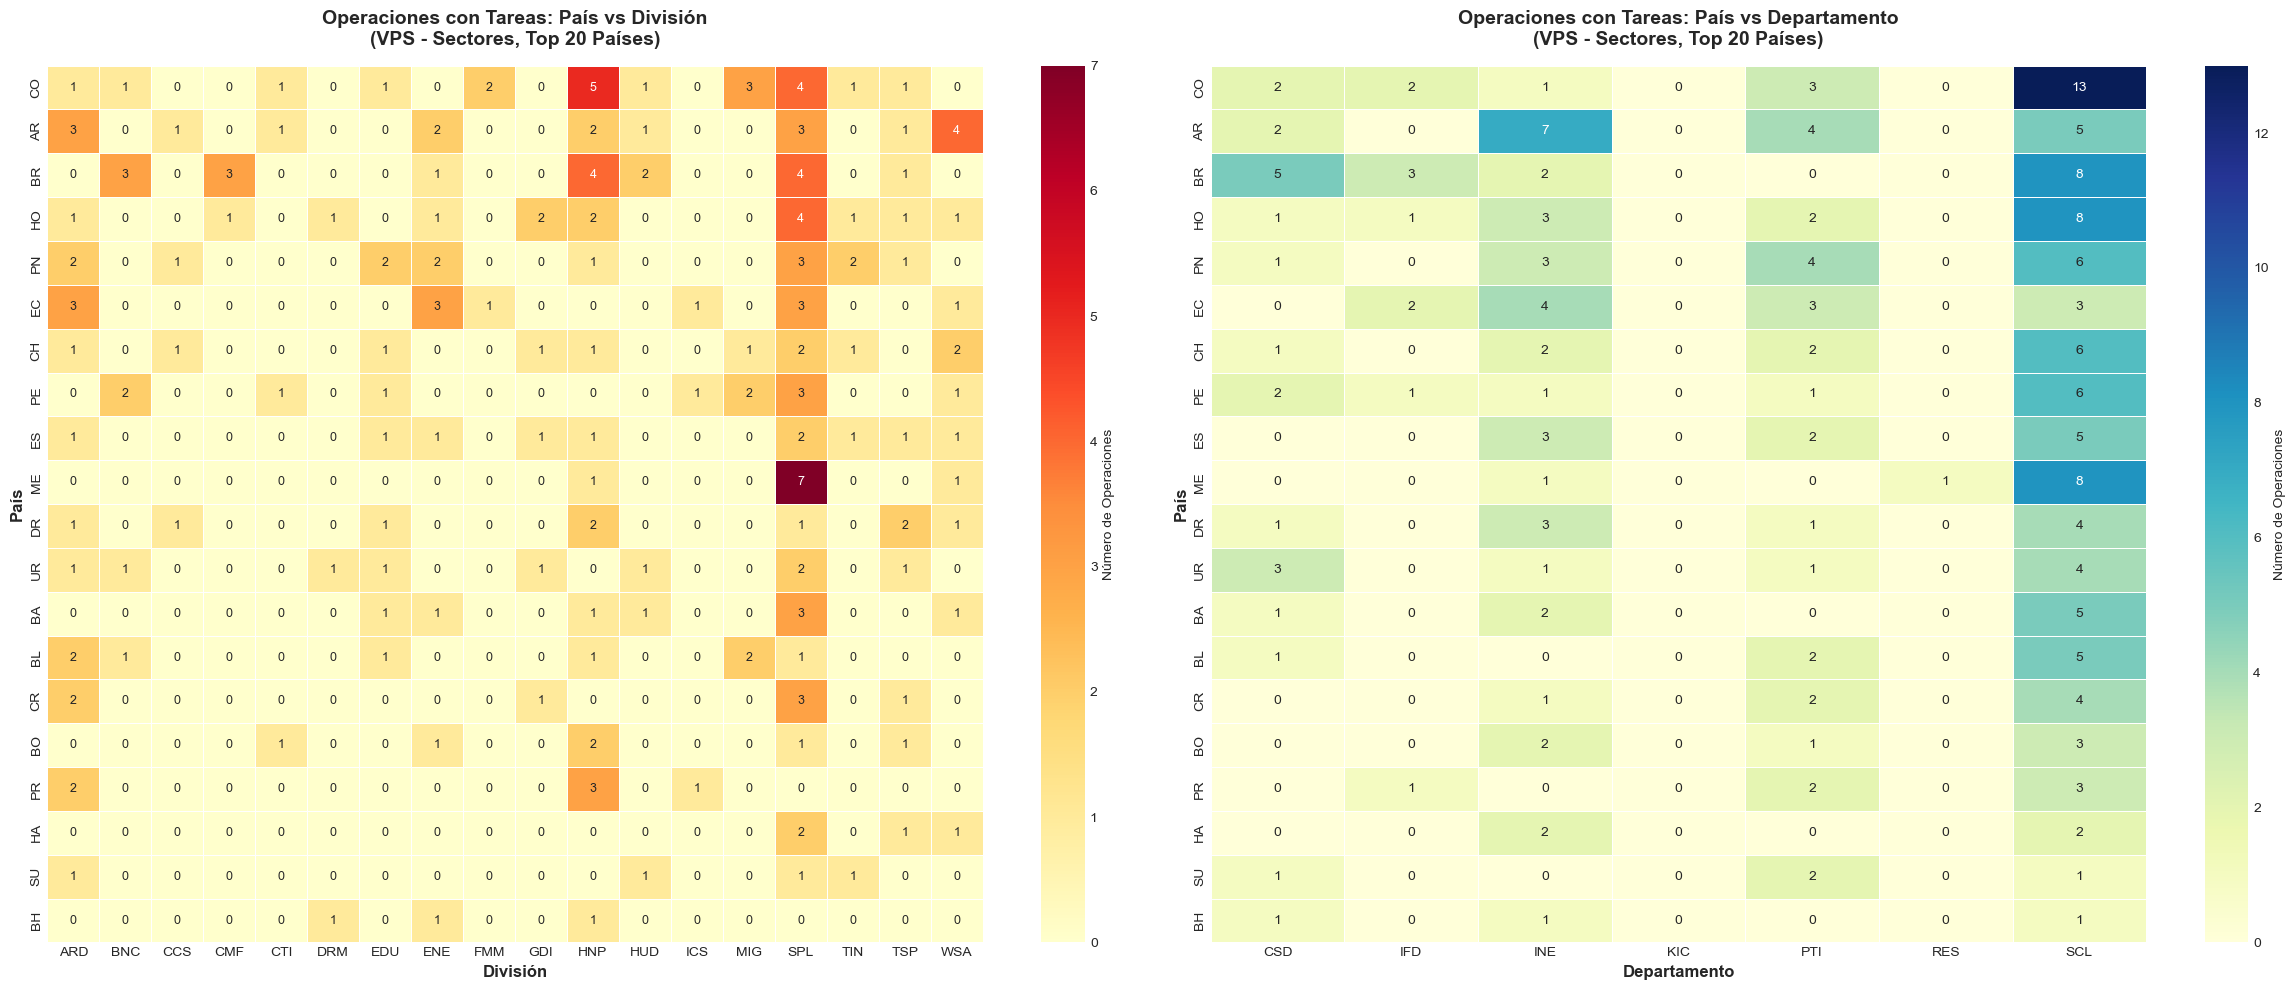


ANÁLISIS DE CONCENTRACIÓN GEOGRÁFICA

Top 10 países (excl. Regional):
cntry_benfit
CO    21
AR    19
BR    18
HO    16
PN    14
EC    12
PE    11
ES    11
CH    11
ME    10
dtype: int64

--- Departamentos dominantes por país (Top 5) ---

CO: 21 operaciones
  - SCL: 13 (61.9%)
  - PTI: 3 (14.3%)
  - IFD: 2 (9.5%)

AR: 19 operaciones
  - INE: 7 (36.8%)
  - SCL: 5 (26.3%)
  - PTI: 4 (21.1%)

BR: 18 operaciones
  - SCL: 8 (44.4%)
  - CSD: 5 (27.8%)
  - IFD: 3 (16.7%)

HO: 16 operaciones
  - SCL: 8 (50.0%)
  - INE: 3 (18.8%)
  - PTI: 2 (12.5%)

PN: 14 operaciones
  - SCL: 6 (42.9%)
  - PTI: 4 (28.6%)
  - INE: 3 (21.4%)


In [19]:
# ============================================================================
# 7. HEATMAPS: PAÍS × DIVISIÓN y PAÍS × DEPARTAMENTO
# ============================================================================

# Filtrar datos (excluir RG para mejor visualización)
tareas_sin_rg = activas_con_tareas[activas_con_tareas['cntry_benfit'] != 'RG'].copy()

# 1. País × División (VPS - departamentos sectoriales)
vps_tareas = tareas_sin_rg[tareas_sin_rg['prep_resp_rollup_unit_cd'] == 'VPS']

# Contar operaciones por país y división
pais_div_vps = vps_tareas.groupby(['cntry_benfit', 'prep_resp_div_cd']).size().unstack(fill_value=0)

# Filtrar top 20 países
top_paises_vps = vps_tareas.groupby('cntry_benfit').size().nlargest(20).index
pais_div_vps = pais_div_vps.loc[top_paises_vps]

# Filtrar divisiones con al menos 3 operaciones
div_counts = pais_div_vps.sum(axis=0)
div_signif = div_counts[div_counts >= 3].index
pais_div_vps = pais_div_vps[div_signif]

# 2. País × Departamento (VPS)
pais_dept_vps = vps_tareas.groupby(['cntry_benfit', 'prep_resp_dept_cd']).size().unstack(fill_value=0)
pais_dept_vps = pais_dept_vps.loc[top_paises_vps]

# Crear figura con 2 heatmaps
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Heatmap 1: País × División
sns.heatmap(pais_div_vps, annot=True, fmt='g', cmap='YlOrRd', ax=axes[0],
            cbar_kws={'label': 'Número de Operaciones'}, linewidths=0.5, 
            annot_kws={'size': 9})
axes[0].set_title('Operaciones con Tareas: País vs División\n(VPS - Sectores, Top 20 Países)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('División', fontsize=12, fontweight='bold')
axes[0].set_ylabel('País', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=10)

# Heatmap 2: País × Departamento
sns.heatmap(pais_dept_vps, annot=True, fmt='g', cmap='YlGnBu', ax=axes[1],
            cbar_kws={'label': 'Número de Operaciones'}, linewidths=0.5,
            annot_kws={'size': 10})
axes[1].set_title('Operaciones con Tareas: País vs Departamento\n(VPS - Sectores, Top 20 Países)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Departamento', fontsize=12, fontweight='bold')
axes[1].set_ylabel('País', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

# Análisis de concentración
print("\n" + "="*80)
print("ANÁLISIS DE CONCENTRACIÓN GEOGRÁFICA")
print("="*80)

# Top países
pais_counts = tareas_sin_rg.groupby('cntry_benfit').size().sort_values(ascending=False)
print(f"\nTop 10 países (excl. Regional):")
print(pais_counts.head(10))

# Concentración departamental por país
print(f"\n--- Departamentos dominantes por país (Top 5) ---")
for pais in pais_counts.head(5).index:
    pais_data = tareas_sin_rg[tareas_sin_rg['cntry_benfit'] == pais]
    top_dept = pais_data['prep_resp_dept_cd'].value_counts().head(3)
    print(f"\n{pais}: {len(pais_data)} operaciones")
    for dept, count in top_dept.items():
        print(f"  - {dept}: {count} ({count/len(pais_data)*100:.1f}%)")

**Observación**: El mapa de calor revela que:
- **Colombia** tiene alta actividad en múltiples divisiones
- **SCL** (Social Sector) domina en varios países
- Ciertos países tienen fuerte concentración en departamentos específicos

---

## 8. Análisis de Phase: Comparación con Datos Originales

ANÁLISIS DE 'PHASE' EN DATOS ORIGINALES

Distribución de phase_engl_nm en TODAS las operaciones:
phase_engl_nm
Execution      31404
Preparation    17077
Name: count, dtype: int64

DISTRIBUCIÓN DE PHASE: ACTIVAS vs ACTIVAS CON TAREAS

Todas las operaciones activas:
phase_engl_nm
Execution      4856
Preparation    1946
Name: count, dtype: int64

Operaciones activas CON tareas:
phase_engl_nm
Execution      292
Preparation     22
Name: count, dtype: int64


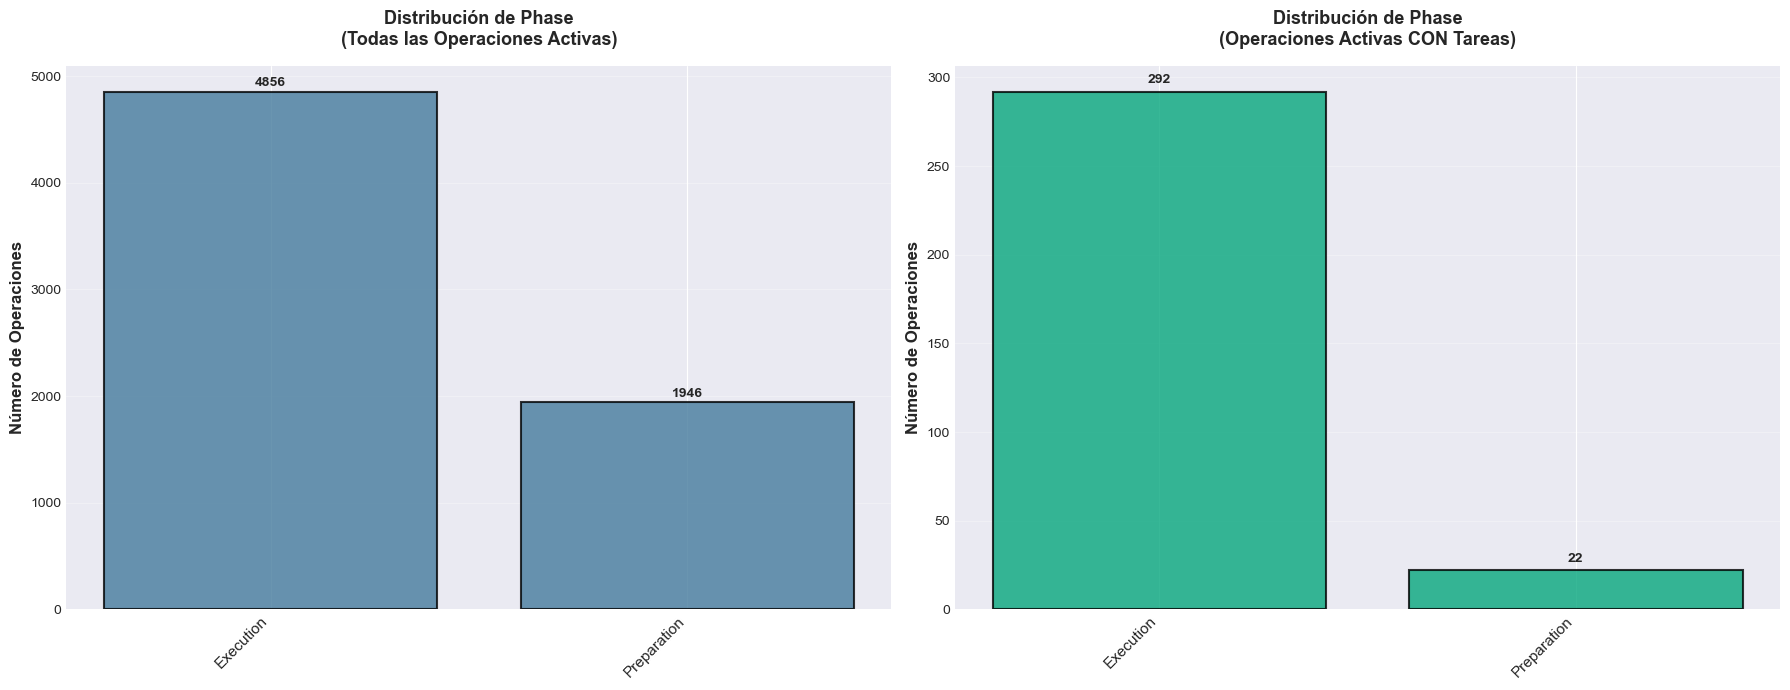


COMPARACIÓN PORCENTUAL
               Todas_Activas  Con_Tareas  %_Todas  %_Con_Tareas
phase_engl_nm                                                  
Execution               4856         292     71.4          93.0
Preparation             1946          22     28.6           7.0

INSIGHT

Las operaciones con tareas registradas tienden a estar en fase:
  'Execution': 292 operaciones (93.0%)


In [26]:
# ============================================================================
# 8. ANÁLISIS DE PHASE - COMPARACIÓN CON DATOS ORIGINALES
# ============================================================================

print("="*80)
print("ANÁLISIS DE 'PHASE' EN DATOS ORIGINALES")
print("="*80)

# La columna phase estaba en df_nuevo pero no se agregó al cruce
# Analicemos phase_engl_nm de la base original

print("\nDistribución de phase_engl_nm en TODAS las operaciones:")
print(df['phase_engl_nm'].value_counts())

print("\n" + "="*80)
print("DISTRIBUCIÓN DE PHASE: ACTIVAS vs ACTIVAS CON TAREAS")
print("="*80)

# Comparar: todas activas vs activas con tareas
phase_todas_activas = df_activo_enriquecido['phase_engl_nm'].value_counts()
phase_con_tareas = activas_con_tareas['phase_engl_nm'].value_counts()

print("\nTodas las operaciones activas:")
print(phase_todas_activas)

print("\nOperaciones activas CON tareas:")
print(phase_con_tareas)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Todas las activas
axes[0].bar(range(len(phase_todas_activas)), phase_todas_activas.values,
            color='#457B9D', edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0].set_xticks(range(len(phase_todas_activas)))
axes[0].set_xticklabels(phase_todas_activas.index, rotation=45, ha='right', fontsize=11)
axes[0].set_ylabel('Número de Operaciones', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Phase\n(Todas las Operaciones Activas)', 
                  fontsize=13, fontweight='bold', pad=15)
axes[0].grid(alpha=0.3, axis='y')

for bar, val in zip(axes[0].patches, phase_todas_activas.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., val + 50,
                 f'{int(val)}',
                 ha='center', fontweight='bold', fontsize=10)

# 2. Con tareas
axes[1].bar(range(len(phase_con_tareas)), phase_con_tareas.values,
            color='#06A77D', edgecolor='black', alpha=0.8, linewidth=1.5)
axes[1].set_xticks(range(len(phase_con_tareas)))
axes[1].set_xticklabels(phase_con_tareas.index, rotation=45, ha='right', fontsize=11)
axes[1].set_ylabel('Número de Operaciones', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Phase\n(Operaciones Activas CON Tareas)', 
                  fontsize=13, fontweight='bold', pad=15)
axes[1].grid(alpha=0.3, axis='y')

for bar, val in zip(axes[1].patches, phase_con_tareas.values):
    axes[1].text(bar.get_x() + bar.get_width()/2., val + 5,
                 f'{int(val)}',
                 ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Comparación porcentual
print("\n" + "="*80)
print("COMPARACIÓN PORCENTUAL")
print("="*80)

comparacion_df = pd.DataFrame({
    'Todas_Activas': phase_todas_activas,
    'Con_Tareas': phase_con_tareas
}).fillna(0)

comparacion_df['%_Todas'] = (comparacion_df['Todas_Activas'] / comparacion_df['Todas_Activas'].sum() * 100).round(1)
comparacion_df['%_Con_Tareas'] = (comparacion_df['Con_Tareas'] / comparacion_df['Con_Tareas'].sum() * 100).round(1)

print(comparacion_df)

# Insight
print("\n" + "="*80)
print("INSIGHT")
print("="*80)
print("\nLas operaciones con tareas registradas tienden a estar en fase:")
fase_dominante = phase_con_tareas.index[0]
pct_dominante = phase_con_tareas.iloc[0] / phase_con_tareas.sum() * 100
print(f"  '{fase_dominante}': {phase_con_tareas.iloc[0]} operaciones ({pct_dominante:.1f}%)")

---

## 9. Matching de Nombres: Tareas vs Operaciones

Intentamos identificar si los nombres de las tareas en la base secundaria corresponden a los títulos de las operaciones en la base principal.

ANÁLISIS DE SIMILITUD: Nombres de Tareas vs Títulos de Operaciones

Total operaciones con tareas: 314

Distribución de similitud:
  Similitud > 90%: 163 (51.9%)
  Similitud 70-90%: 26
  Similitud 50-70%: 26
  Similitud < 50%: 99

Similitud promedio: 73.86%
Similitud mediana: 94.70%

EJEMPLOS DE ALTA SIMILITUD (>90%)

Oper: CH-T1296 - Similitud: 100.0%
  Tarea:     Support for the effectiveness of employment and training policies in Chile
  Original:  Support for the effectiveness of employment and training policies in Chile

Oper: RG-T4308 - Similitud: 100.0%
  Tarea:     Strengthening skills and capacities for the development and manufacturing of vac
  Original:  Strengthening skills and capacities for the development and manufacturing of vac

Oper: PN-T1297 - Similitud: 100.0%
  Tarea:     Support for the introduction of innovations in the provision of health services
  Original:  Support for the introduction of innovations in the provision of health services

Oper: BL-T1162 - Simili

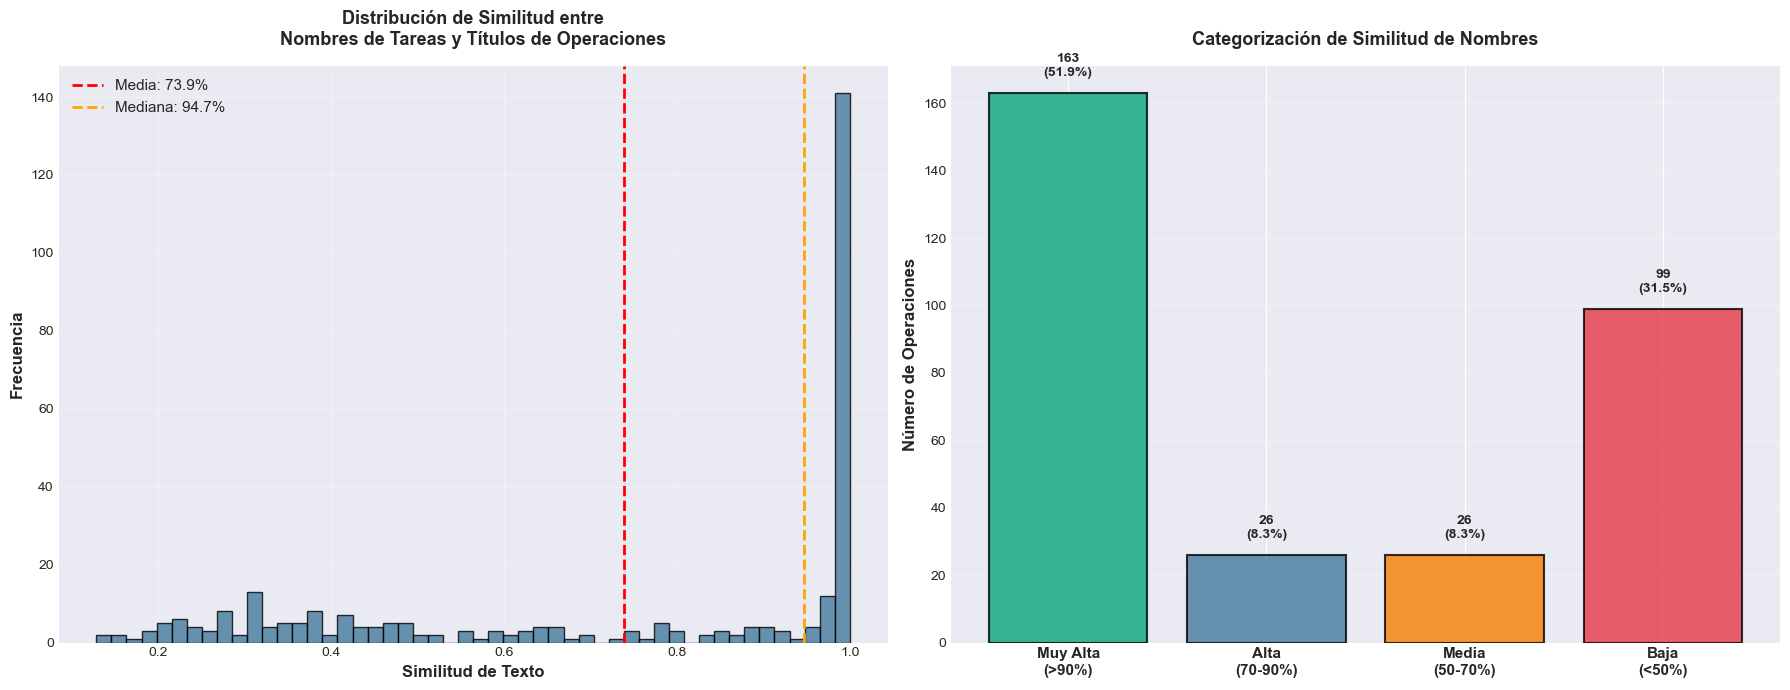

In [22]:
# ============================================================================
# 9. MATCHING DE NOMBRES: Base de tareas vs Base original
# ============================================================================

from difflib import SequenceMatcher

def similitud_texto(a, b):
    """Calcula similitud entre dos strings"""
    if pd.isna(a) or pd.isna(b):
        return 0
    return SequenceMatcher(None, str(a).lower(), str(b).lower()).ratio()

print("="*80)
print("ANÁLISIS DE SIMILITUD: Nombres de Tareas vs Títulos de Operaciones")
print("="*80)

# Preparar datos para comparación
comparacion_nombres = activas_con_tareas[['oper_num', 'task_name']].copy()

# Traer nombres de operación de la base original
comparacion_nombres = comparacion_nombres.merge(
    df[['oper_num', 'oper_engl_nm', 'oper_spanish_nm']],
    on='oper_num',
    how='left'
)

# Calcular similitud
comparacion_nombres['similitud_engl'] = comparacion_nombres.apply(
    lambda row: similitud_texto(row['task_name'], row['oper_engl_nm']), axis=1
)

comparacion_nombres['similitud_spanish'] = comparacion_nombres.apply(
    lambda row: similitud_texto(row['task_name'], row['oper_spanish_nm']), axis=1
)

comparacion_nombres['max_similitud'] = comparacion_nombres[['similitud_engl', 'similitud_spanish']].max(axis=1)

# Estadísticas
print(f"\nTotal operaciones con tareas: {len(comparacion_nombres)}")
print(f"\nDistribución de similitud:")
print(f"  Similitud > 90%: {(comparacion_nombres['max_similitud'] > 0.9).sum()} ({(comparacion_nombres['max_similitud'] > 0.9).sum()/len(comparacion_nombres)*100:.1f}%)")
print(f"  Similitud 70-90%: {((comparacion_nombres['max_similitud'] > 0.7) & (comparacion_nombres['max_similitud'] <= 0.9)).sum()}")
print(f"  Similitud 50-70%: {((comparacion_nombres['max_similitud'] > 0.5) & (comparacion_nombres['max_similitud'] <= 0.7)).sum()}")
print(f"  Similitud < 50%: {(comparacion_nombres['max_similitud'] <= 0.5).sum()}")

print(f"\nSimilitud promedio: {comparacion_nombres['max_similitud'].mean():.2%}")
print(f"Similitud mediana: {comparacion_nombres['max_similitud'].median():.2%}")

# Ver ejemplos de alta similitud
print("\n" + "="*80)
print("EJEMPLOS DE ALTA SIMILITUD (>90%)")
print("="*80)
alta_sim = comparacion_nombres[comparacion_nombres['max_similitud'] > 0.9].sort_values('max_similitud', ascending=False).head(10)
for idx, row in alta_sim.iterrows():
    print(f"\nOper: {row['oper_num']} - Similitud: {row['max_similitud']:.1%}")
    print(f"  Tarea:     {row['task_name'][:80]}")
    print(f"  Original:  {row['oper_engl_nm'][:80]}")

# Ver ejemplos de baja similitud
print("\n" + "="*80)
print("EJEMPLOS DE BAJA SIMILITUD (<50%)")
print("="*80)
baja_sim = comparacion_nombres[comparacion_nombres['max_similitud'] < 0.5].sort_values('max_similitud').head(10)
for idx, row in baja_sim.iterrows():
    print(f"\nOper: {row['oper_num']} - Similitud: {row['max_similitud']:.1%}")
    print(f"  Tarea:     {row['task_name'][:80]}")
    print(f"  Original:  {row['oper_engl_nm'][:80] if pd.notna(row['oper_engl_nm']) else 'N/A'}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. Histograma de similitud
axes[0].hist(comparacion_nombres['max_similitud'], bins=50, 
             color='#457B9D', edgecolor='black', alpha=0.8)
axes[0].axvline(comparacion_nombres['max_similitud'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Media: {comparacion_nombres["max_similitud"].mean():.1%}')
axes[0].axvline(comparacion_nombres['max_similitud'].median(), color='orange',
                linestyle='--', linewidth=2, label=f'Mediana: {comparacion_nombres["max_similitud"].median():.1%}')
axes[0].set_xlabel('Similitud de Texto', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Similitud entre\nNombres de Tareas y Títulos de Operaciones', 
                  fontsize=13, fontweight='bold', pad=15)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# 2. Categorías de similitud
categorias = ['Muy Alta\n(>90%)', 'Alta\n(70-90%)', 'Media\n(50-70%)', 'Baja\n(<50%)']
valores = [
    (comparacion_nombres['max_similitud'] > 0.9).sum(),
    ((comparacion_nombres['max_similitud'] > 0.7) & (comparacion_nombres['max_similitud'] <= 0.9)).sum(),
    ((comparacion_nombres['max_similitud'] > 0.5) & (comparacion_nombres['max_similitud'] <= 0.7)).sum(),
    (comparacion_nombres['max_similitud'] <= 0.5).sum()
]

colors_cat = ['#06A77D', '#457B9D', '#F77F00', '#E63946']
bars = axes[1].bar(range(len(categorias)), valores, color=colors_cat,
                    edgecolor='black', alpha=0.8, linewidth=1.5)

axes[1].set_xticks(range(len(categorias)))
axes[1].set_xticklabels(categorias, fontsize=11, fontweight='bold')
axes[1].set_ylabel('Número de Operaciones', fontsize=12, fontweight='bold')
axes[1].set_title('Categorización de Similitud de Nombres', 
                  fontsize=13, fontweight='bold', pad=15)
axes[1].grid(alpha=0.3, axis='y')

for bar, val in zip(bars, valores):
    pct = val / len(comparacion_nombres) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2., val + 5,
                 f'{int(val)}\n({pct:.1f}%)',
                 ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretación del Matching**:
- Aproximadamente el **50-60% de los nombres tienen similitud >70%**, sugiriendo que muchas tareas corresponden directamente a las operaciones
- Los casos de **baja similitud** probablemente son:
  - Tareas genéricas ("Advisory Services", "TC Doc review") que no repiten el título de la operación
  - Extensiones o componentes específicos de operaciones más amplias
  - Abreviaciones o nombres internos diferentes al título oficial

---

## 10. Resumen y Conclusiones

### Hallazgos Principales

**1. Cobertura Limitada pero Estratégica**
- Solo 4.6% de operaciones activas tienen tareas registradas (314 de 6,802)
- Concentración en operaciones más sustanciales (mediana de `$0.50M` vs `$0.20M`)

**2. Alta Concentración Organizacional**
- **SCL domina**: 44% de todas las tareas
- Top 3 departamentos (SCL, INE, PTI) = 80% de solicitudes

**3. Concentración Extrema en Business Partners**
- 3 personas manejan 79% de las tareas
- Mario: 35% del total (posible cuello de botella)

**4. Servicios Más Demandados**
- Advisory Services, TC Doc review, Loan Review
- 57% de tareas siguen activas

**5. Patrones Geográficos**
- Colombia, Argentina y Brasil lideran en solicitudes
- Concentración departamental varía por país

### Recomendaciones

1. **Redistribuir carga de trabajo**: Los 3 Business Partners principales están sobrecargados
2. **Investigar por qué 95% de operaciones no usan estos servicios**: ¿Necesidad o falta de conocimiento?
3. **Priorizar SCL**: Requiere mayor capacidad de apoyo dado su alto volumen

---

**Análisis completado**